In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Задание

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.
2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.
3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

## **Реализация алгоритма градиентного бустинга**

In [2]:
import numpy as np
import matplotlib

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn.datasets import load_diabetes
%matplotlib inline

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и 
    # при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees, max_depth):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [10]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Amount trees')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [11]:
# # Число деревьев в ансамбле
# n_trees = 10

# # для простоты примем коэффициенты равными 1
# coefs = [1] * n_trees

# # Максимальная глубина деревьев
# max_depth = 3

# # Шаг
# eta = 0.19

**1.** Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.


In [12]:
def get_coefs(n_trees):
    return [1] * n_trees

In [13]:
def test_gb(etas, n_trees, max_depth, show=False):
    for eta in etas:
        for tree in n_trees:
            coefs = get_coefs(tree)
            for depth in max_depth:
                trees, train_errors, test_errors = gb_fit(tree, depth, X_train, X_test, y_train, y_test, coefs, eta)
                evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, tree, depth)
                print()
                if show:
                    get_error_plot(tree, train_errors, test_errors)

In [14]:
etas = [0.1, 0.01, 0.05]
n_trees = [3, 10, 50]
max_depth = np.arange(3, 8)

Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 16665.03930579392
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 17596.918652057993



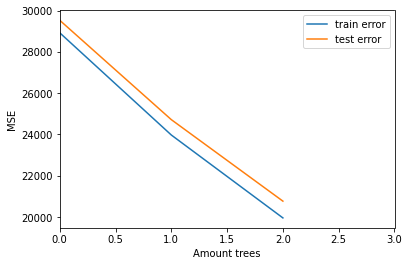

Ошибка алгоритма из 3 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 16470.747622530987
Ошибка алгоритма из 3 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 17588.354009943978



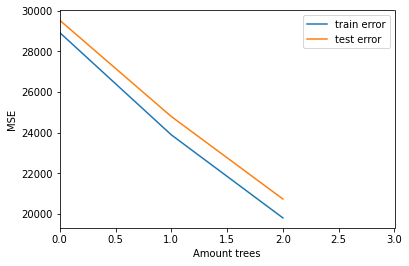

Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 16273.182446449302
Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 17607.943290587235



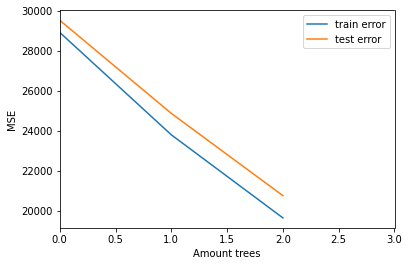

Ошибка алгоритма из 3 деревьев глубиной 6     с шагом 0.1 на тренировочной выборке: 16055.92834748724
Ошибка алгоритма из 3 деревьев глубиной 6     с шагом 0.1 на тестовой выборке: 17673.71064135853



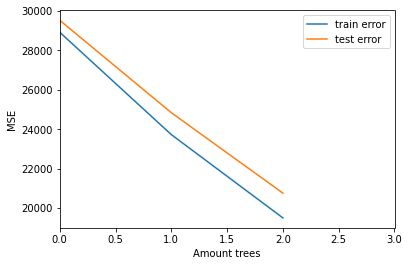

Ошибка алгоритма из 3 деревьев глубиной 7     с шагом 0.1 на тренировочной выборке: 15834.868271779505
Ошибка алгоритма из 3 деревьев глубиной 7     с шагом 0.1 на тестовой выборке: 17587.74374417717



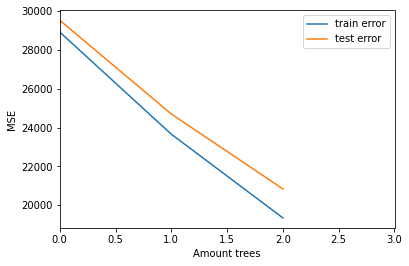

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 5675.523239265927
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 7007.596819271277



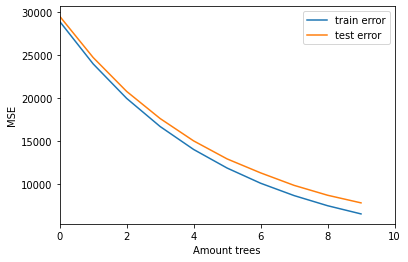

Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 5250.71040606794
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 6776.46161087326



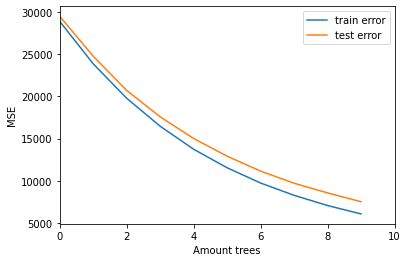

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 4845.403824047214
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 6974.728252391131



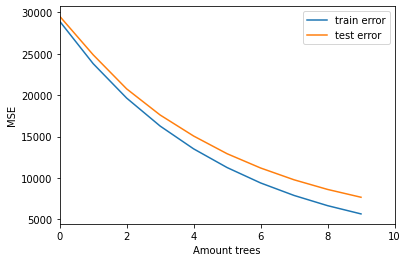

Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 0.1 на тренировочной выборке: 4352.901339137293
Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 0.1 на тестовой выборке: 7421.875977201511



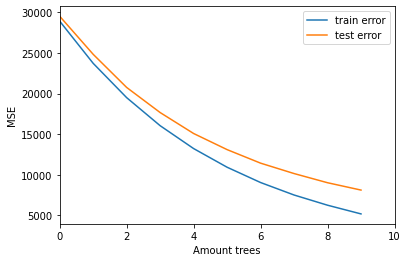

Ошибка алгоритма из 10 деревьев глубиной 7     с шагом 0.1 на тренировочной выборке: 4025.8015543384145
Ошибка алгоритма из 10 деревьев глубиной 7     с шагом 0.1 на тестовой выборке: 7239.579276314024



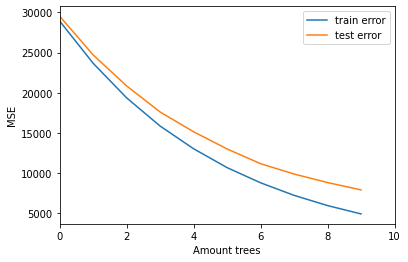

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1477.022738004668
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3329.107372253614



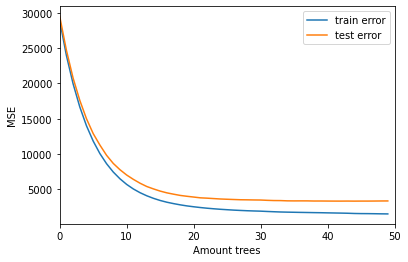

Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.1 на тренировочной выборке: 801.1605847528043
Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.1 на тестовой выборке: 3271.3163782504885



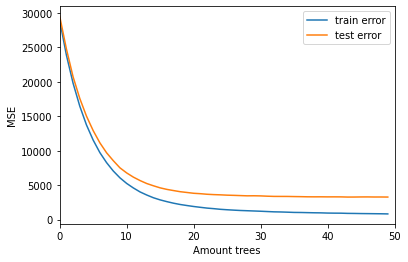

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 356.748450334306
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3605.25871800454



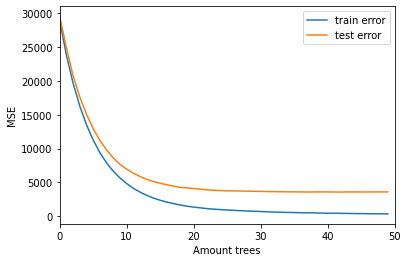

Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.1 на тренировочной выборке: 129.27353971209658
Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.1 на тестовой выборке: 3941.2607048872014



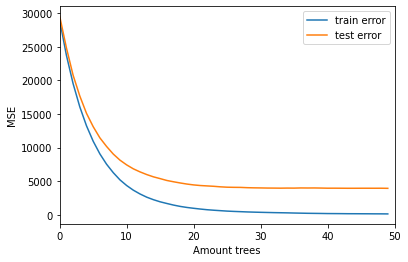

Ошибка алгоритма из 50 деревьев глубиной 7     с шагом 0.1 на тренировочной выборке: 23.27397824410757
Ошибка алгоритма из 50 деревьев глубиной 7     с шагом 0.1 на тестовой выборке: 3947.1316612329115



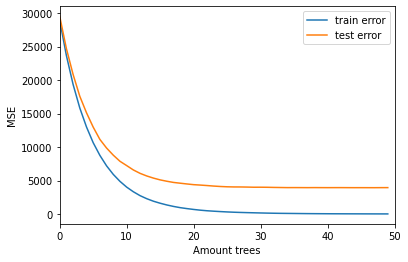

Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 27395.859650120085
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 28048.88070796601



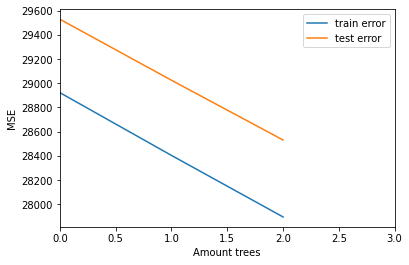

Ошибка алгоритма из 3 деревьев глубиной 4     с шагом 0.01 на тренировочной выборке: 27370.87211602556
Ошибка алгоритма из 3 деревьев глубиной 4     с шагом 0.01 на тестовой выборке: 28070.928986505176



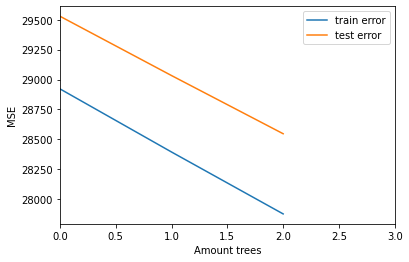

Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.01 на тренировочной выборке: 27345.655706470574
Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 28096.443304920846



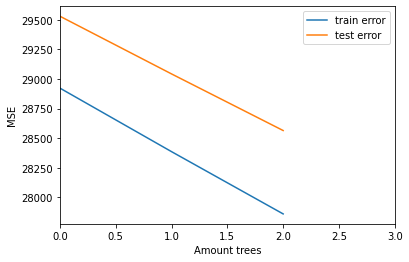

Ошибка алгоритма из 3 деревьев глубиной 6     с шагом 0.01 на тренировочной выборке: 27321.8641175688
Ошибка алгоритма из 3 деревьев глубиной 6     с шагом 0.01 на тестовой выборке: 28080.071425011873



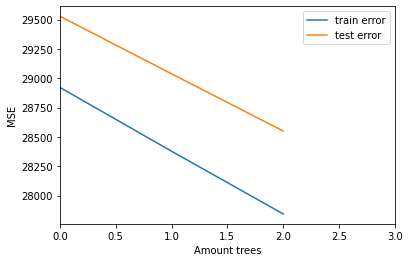

Ошибка алгоритма из 3 деревьев глубиной 7     с шагом 0.01 на тренировочной выборке: 27298.714243458566
Ошибка алгоритма из 3 деревьев глубиной 7     с шагом 0.01 на тестовой выборке: 28036.487211651252



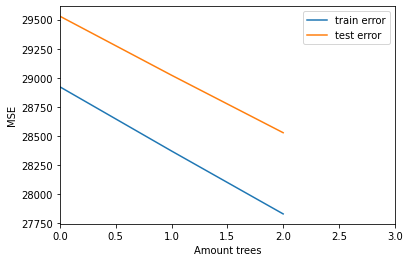

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 24172.080801549346
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 24913.446759958126



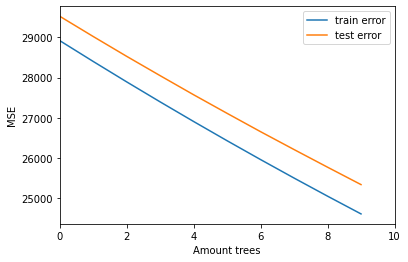

Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.01 на тренировочной выборке: 24095.114709739482
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.01 на тестовой выборке: 24950.496425007004



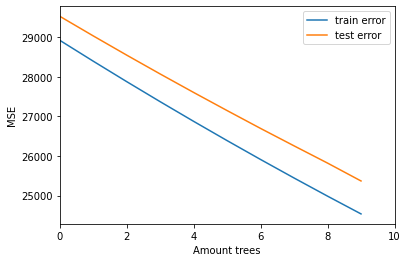

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.01 на тренировочной выборке: 24016.1693920674
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 24979.824540357815



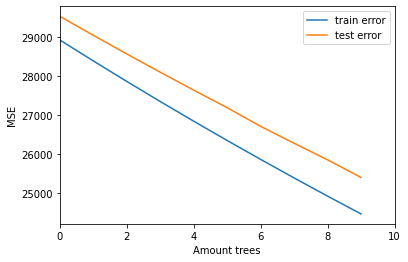

Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 0.01 на тренировочной выборке: 23935.883598128483
Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 0.01 на тестовой выборке: 24986.8619042692



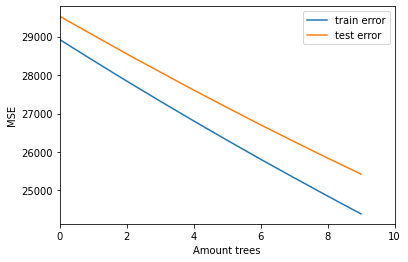

Ошибка алгоритма из 10 деревьев глубиной 7     с шагом 0.01 на тренировочной выборке: 23861.496240389053
Ошибка алгоритма из 10 деревьев глубиной 7     с шагом 0.01 на тестовой выборке: 24896.63166981373



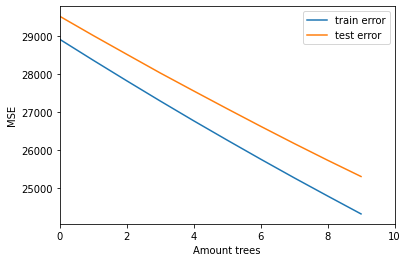

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 12288.822219700683
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 13388.836967181538



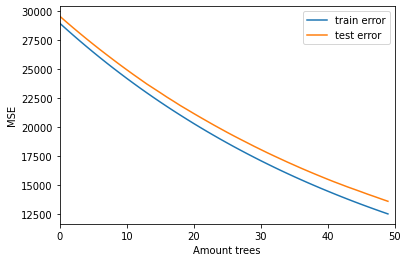

Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.01 на тренировочной выборке: 11989.043843669671
Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.01 на тестовой выборке: 13340.16328035761



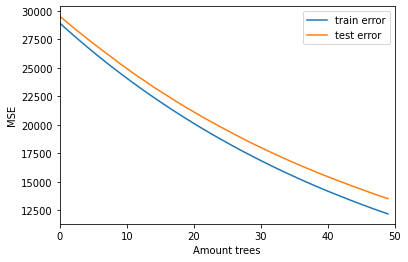

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.01 на тренировочной выборке: 11703.923120166697
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.01 на тестовой выборке: 13326.02276564237



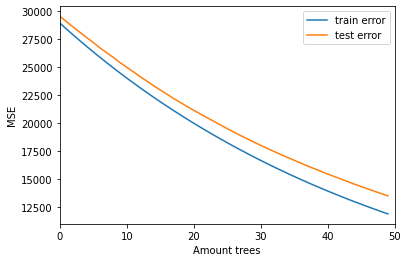

Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.01 на тренировочной выборке: 11441.536988290476
Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.01 на тестовой выборке: 13475.755784236027



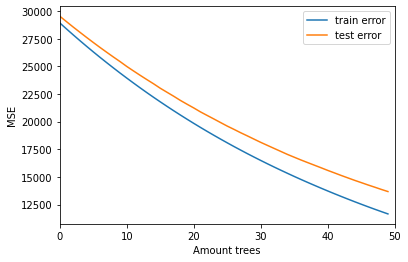

Ошибка алгоритма из 50 деревьев глубиной 7     с шагом 0.01 на тренировочной выборке: 11126.435894968448
Ошибка алгоритма из 50 деревьев глубиной 7     с шагом 0.01 на тестовой выборке: 13441.801330876306



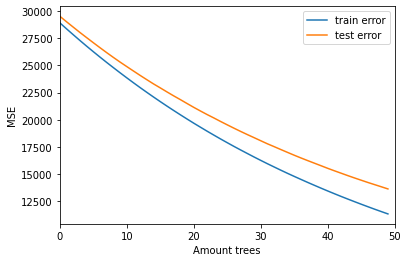

Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 22010.624690409248
Ошибка алгоритма из 3 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 22788.667418789835



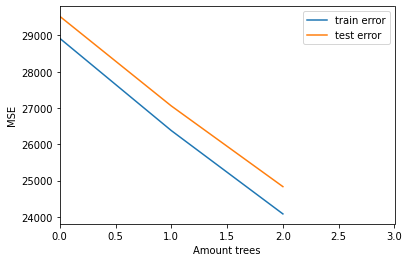

Ошибка алгоритма из 3 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 21893.50841658978
Ошибка алгоритма из 3 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 22764.184867930653



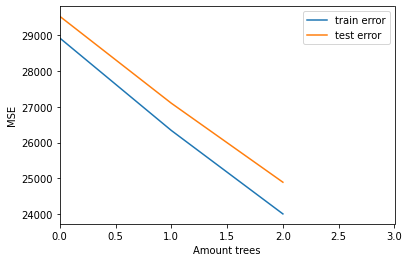

Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 21782.835819562977
Ошибка алгоритма из 3 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 22791.471431832673



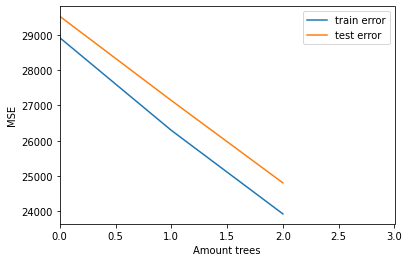

Ошибка алгоритма из 3 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 21668.576317008243
Ошибка алгоритма из 3 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 22804.538152122223



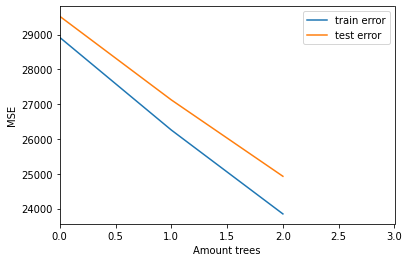

Ошибка алгоритма из 3 деревьев глубиной 7     с шагом 0.05 на тренировочной выборке: 21547.293155335214
Ошибка алгоритма из 3 деревьев глубиной 7     с шагом 0.05 на тестовой выборке: 22802.376929570022



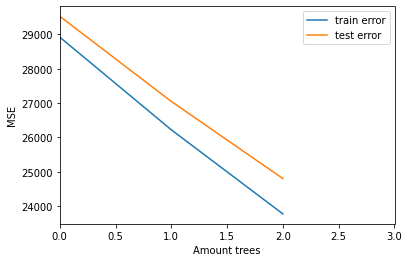

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 12089.163702686777
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 13185.771145873963



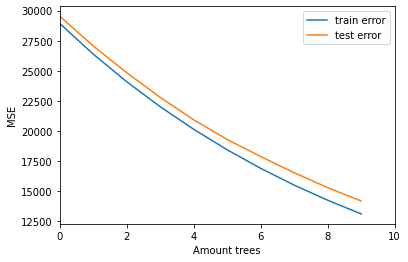

Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 11784.961627783481
Ошибка алгоритма из 10 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 13096.726237008254



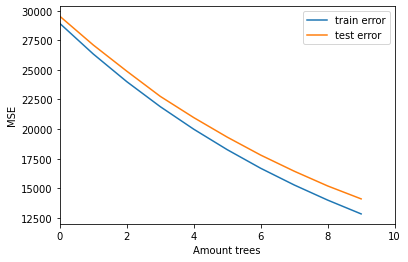

Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 11495.10041932117
Ошибка алгоритма из 10 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 13113.274325678161



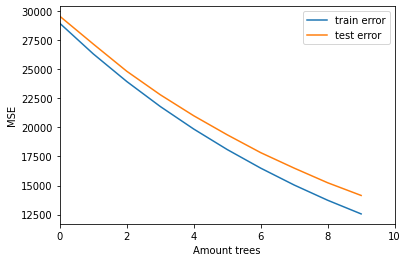

Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 11222.437530720566
Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 13320.030962279829



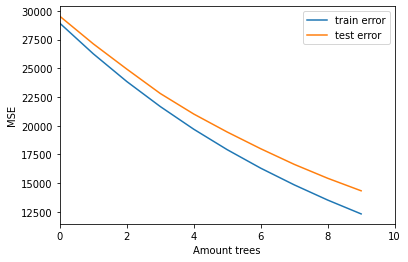

Ошибка алгоритма из 10 деревьев глубиной 7     с шагом 0.05 на тренировочной выборке: 10926.381532102705
Ошибка алгоритма из 10 деревьев глубиной 7     с шагом 0.05 на тестовой выборке: 13289.15118730906



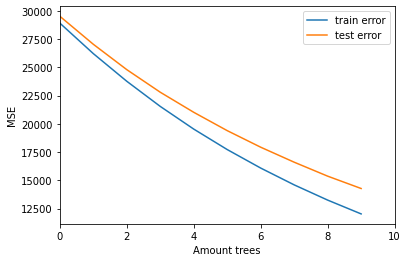

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.05 на тренировочной выборке: 2081.4104215611464
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.05 на тестовой выборке: 3501.9347399607827



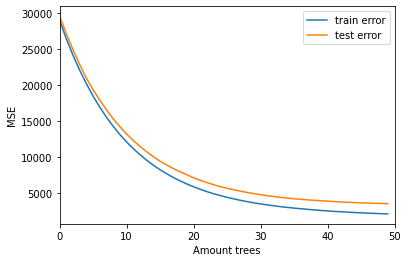

Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.05 на тренировочной выборке: 1471.8422351984511
Ошибка алгоритма из 50 деревьев глубиной 4     с шагом 0.05 на тестовой выборке: 3540.9609912451783



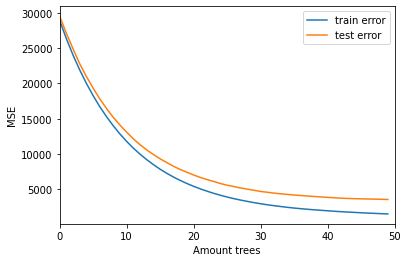

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.05 на тренировочной выборке: 978.5634399908892
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.05 на тестовой выборке: 3608.974766737515



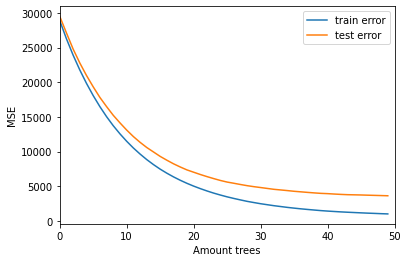

Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.05 на тренировочной выборке: 596.5221533286409
Ошибка алгоритма из 50 деревьев глубиной 6     с шагом 0.05 на тестовой выборке: 3895.1008488436414



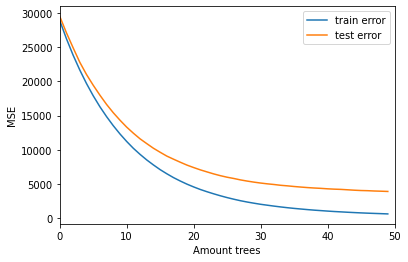

Ошибка алгоритма из 50 деревьев глубиной 7     с шагом 0.05 на тренировочной выборке: 349.3526219026683
Ошибка алгоритма из 50 деревьев глубиной 7     с шагом 0.05 на тестовой выборке: 4065.845149569967



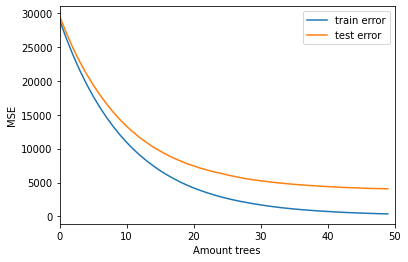

In [15]:
test_gb(etas=etas, n_trees=n_trees, max_depth=max_depth, show=True)

При увеличении количества деревьев и максимальной глубины деревьев уменьшается значение ошибки, однако модель явно склонна к переобучению, что в свою очередь можно попробовать решить подбором параметра шага (eta)

**2.** Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [16]:
from random import choices

In [17]:
def gb_fit_stoh(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        idx_list = list(range(0, X_train.shape[0]))
        idx = choices(idx_list, k=X_train.shape[0] // 2)
        idx = list(set(idx))
        
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[idx], y_train[idx])
            
            train_errors.append(mean_squared_error(y_train[idx], gb_predict(X_train[idx], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train[idx], trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[idx], bias(y_train[idx], target))
            
            train_errors.append(mean_squared_error(y_train[idx], gb_predict(X_train[idx], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [18]:
n_trees = 50
max_depth = 7
eta = 0.1
coefs = [1] * n_trees

In [19]:
trees, train_errors, test_errors = gb_fit_stoh(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [20]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, n_trees=n_trees, max_depth=max_depth)

Ошибка алгоритма из 50 деревьев глубиной 7     с шагом 0.1 на тренировочной выборке: 328.3598084767476
Ошибка алгоритма из 50 деревьев глубиной 7     с шагом 0.1 на тестовой выборке: 3688.067513760266


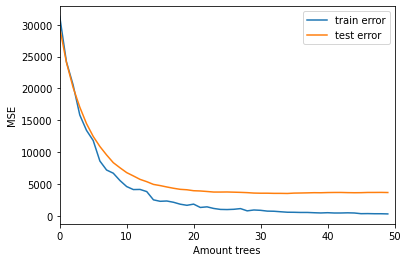

In [21]:
get_error_plot(n_trees, train_errors, test_errors)

Увеличелась ошибка на тренировочной выборке, при этом уменьшилась на тестовой выборке